In [1]:
%reload_ext autoreload
%autoreload 2

# Exploring Instacart Purchase Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from youchoose.data.ingestion import sql as sql_loader

In [3]:
sns.set(style="white", context="talk")
sns.set_palette(sns.color_palette("colorblind"))

### Connect to the Database

The data that is downloaded from Instacart is stored as seperate CSV files. However, the data that we will use for exploration and analysis is contained in a Postgres database hosted on ASW. To connect to the database, we use a .env file to store the hostname and passwords needed for the connection.

If you want information about creating a Postgres database from CVS files, you can check out my [blog post]() where I step-by-step through the process on a EC2 instance.

After connecting to the database, I prefer to use raw SQL queries, but they can also be made using sqlalchemy commands.

In [4]:
instart_database = sql_loader.SQLDatabase()

# check to make sure the tables contained in the database are what we expect them to be.
print(f"table names: {', '.join(instart_database.table_names)}")

table names: orders_no_tests, orders_test, departments, orders, aisles, products, order_products__prior, order_products__train


## When Are Orders Made?

### Time of Purchase

In [5]:
time_of_query = """
    SELECT o.order_dow AS day, o.order_hour_of_day AS hour , COUNT(*)
    FROM orders as o
    WHERE o.eval_set='prior'
    GROUP BY 1, 2
    ORDER BY 3 DESC
;
"""

time_of = instart_database.get_dataframe(time_of_query)

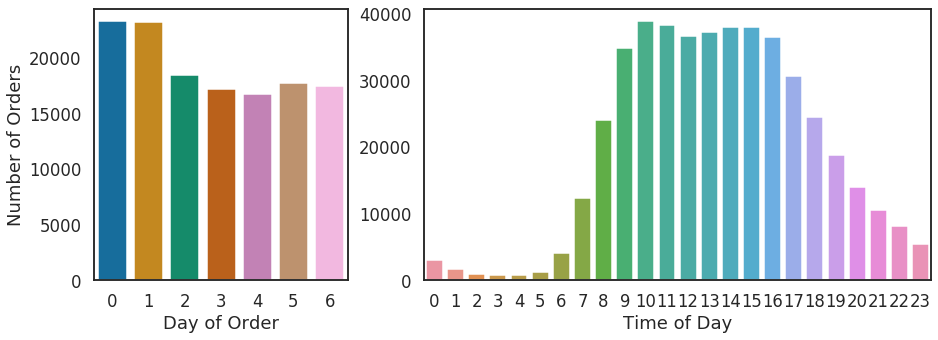

In [6]:
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5), gridspec_kw={'width_ratios': [1, 2]})
sns.barplot(x="day", y="count", data=time_of, ax=ax, ci=None)
ax.set_xlabel("Day of Order")
ax.set_ylabel("Number of Orders")
sns.barplot(x="hour", y="count", data=time_of, ax=ax2, ci=None)
ax2.set_xlabel("Time of Day")
ax2.set_ylabel("")
plt.show()

### Time Between Orders

In [7]:
time_between_query = """
    SELECT CAST(o.days_since_prior AS TEXT), (COUNT(o.days_since_prior) * 100.0 / (SELECT COUNT(*) FROM orders)) AS percent
    FROM orders as o
    WHERE o.eval_set='prior'
    GROUP BY 1
;
"""

time_between = instart_database.get_dataframe(time_between_query)
time_between.days_since_prior.replace("30", "30+", inplace=True)

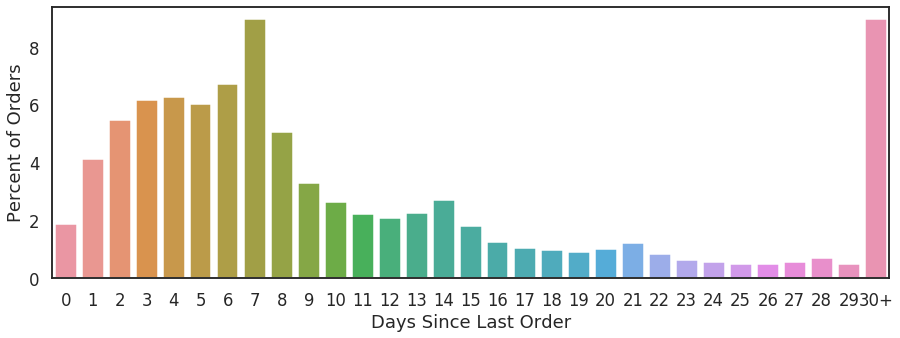

In [8]:
ordered_days = ([str(x) for x in range(30)] + ["30+"])
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="days_since_prior", y="percent", data=time_between, ax=ax, order=ordered_days)
ax.set_xlabel("Days Since Last Order")
ax.set_ylabel("Percent of Orders")
plt.show()

It would be interesting to also include the number of products that are made each day to see if that is signigicantly different between the days.

## Product Information

### First Item Placed In Baskets

In [9]:
first_item_query = """
    SELECT products.product_name, COUNT(p.product_id)
    FROM order_products__prior as p
    INNER JOIN orders as o
    ON o.order_id=p.order_id
    INNER JOIN products
    ON products.product_id= p.product_id
    WHERE p.add_to_cart_order=1
    GROUP BY products.product_name
    ORDER BY COUNT(p.product_id) DESC
    LIMIT 20;
"""

first_items = instart_database.get_dataframe(first_item_query)

In [10]:
first_items

,product_name,count
0,Banana,115521
1,Bag of Organic Bananas,82877
2,Organic Whole Milk,32071
3,Organic Strawberries,28875
4,Organic Hass Avocado,24913
5,Organic Baby Spinach,24412
6,Organic Avocado,23393
7,Spring Water,17552
8,Strawberries,17073
9,Organic Raspberries,14950


Looking at the table we see that many products have both organic and non-organic product names that are separate items. If you wanted to look at a broader definition, say "milk", we would need to be able to group names that contain similar terms.

Another interesting observation is that many of the first products added to the shopping cart are in the produce department. In a physical store that makes a lot of sense as that is usually the first department you enter in a store. In an online shopping experience, do people add it because they are used to doing that in a store, is that what is promoted on the app, or is it just by chance? One way to try and figure this out would be to run A/B tests on the app to see if the first department promoted correlates with what item place in their carts first.

### Frequent Products

In [19]:
most_bought_query = """
    SELECT p.product_name, a.aisle, d.department, COUNT(*) AS number_of_purchases
    FROM order_products__prior o
    INNER JOIN products p
    ON p.product_id=o.product_id
    INNER JOIN aisles a
    ON a.aisle_id=p.aisle_id
    INNER JOIN departments d
    ON d.department_id=p.department_id
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
;
"""

most_bought = instart_database.get_dataframe(most_bought_query)

In [21]:
most_bought.head(15)

,product_name,aisle,department,number_of_purchases
0,Banana,fresh fruits,produce,491291
1,Bag of Organic Bananas,fresh fruits,produce,394930
2,Organic Strawberries,fresh fruits,produce,275577
3,Organic Baby Spinach,packaged vegetables fruits,produce,251705
4,Organic Hass Avocado,fresh fruits,produce,220877
5,Organic Avocado,fresh fruits,produce,184224
6,Large Lemon,fresh fruits,produce,160792
7,Strawberries,fresh fruits,produce,149445
8,Limes,fresh fruits,produce,146660
9,Organic Whole Milk,milk,dairy eggs,142813


This query is a little longer to run, so I save the resulting dataframe to a CSV file for future use.

In [20]:
most_bought.to_csv("../data/interim/product_purchases.csv")

All except 1 of the most frequently purchased items is in the produce department, the lone exception being organic whole milk. It's clear that Instacart users tend to prefer organic items with 11 of the top 15 items bought are organic.